# Extraction of features for different models of error-related brain activity and anxiety dimensions

### Imports

In [1]:
import os
import sys
import re
import glob
import ast
import os.path as op
import pickle
import mne
import scipy
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

from collections import defaultdict

from copy import deepcopy
import copy

import pygsp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.utils import resample
from sklearn.covariance import GraphicalLassoCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from scipy.interpolate import UnivariateSpline
from scipy.integrate import simpson
from scipy.stats import boxcox
from sklearn.metrics import auc


from scipy.stats import pearsonr

from autoreject import AutoReject

from transformers import *

import warnings
warnings.filterwarnings("ignore")

---
## Load data

Loading EEG data and data from rumination questionnaire. By default create_df_data loads all info from given file but one can specify it by passing a list of desired labels from csv file.

In [2]:
# paths TODO
dir_path = os.path.dirname(os.path.abspath(""))

In [3]:
tmin, tmax = -0.1, 0.6  # Start and end of the segments
signal_frequency = 256
random_state = 0

In [4]:
def create_df_data(
    test_participants=False,
    test_epochs=False,
    info_filename=None,
    info="all",
    personal=True,
):
    """Loads data for all participants and create DataFrame with optional additional info from given .csv file.

    On default, loads a train set: chooses only 80% of participants
    and for each of them chooses 80% of epochs.
    It will choose them deterministically.

    Participants with less than 10 epochs per condition are rejected.

    If test_participants is set to True, it will load remaining 20% of participants.
    If test_epochs is set to True, it will load remaining 20% of epochs.
    Test epochs are chronologically after train epochs,
    because it reflects real usage (first callibration and then classification).

    Parameters
    ----------
    test_participants: bool
        whether load data for training or final testing.
        If true load participants data for testing.
    test_epochs: bool
        whether load data for training or final testing.
        If true load epochs of each participants data for testing.
    info_filename: String | None
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters
    personal: bool
        whether a model will be both trained and tested on epochs from one person
        if false, person's epochs aren't split into test and train


    Returns
    -------
    go_nogo_data_df : pandas.DataFrame

    """
    print(os.path.abspath(""))
    dir_path = os.path.dirname(os.path.abspath(""))
    print(dir_path)
    header_files_glob = os.path.join(dir_path, "data/responses_100_600_sonata/*.vhdr")
    header_files = glob.glob(header_files_glob)

    header_files = sorted(header_files)
    go_nogo_data_df = pd.DataFrame()

    # cut 20% of data for testing
    h_train, h_test = train_test_split(header_files, test_size=0.3, random_state=0)
    
    print(f"train size: {len(h_train)} ; test size: {len(h_test)}")

    if test_participants:
        header_files = h_test
    else:
        header_files = h_train

    for file in header_files:
        #  load eeg data for given participant
        participant_epochs = load_epochs_from_file(file)

        # and compute participant's id from file_name
        participant_id = re.match(r".*GNG-(\d+).*", file).group(1)

        error = participant_epochs["error_response"]._data
        correct = participant_epochs["correct_response"]._data

        # exclude those participants who have too few samples
        if len(error) < 5 or len(correct) < 5:
            # not enough data for this participant
            continue

        # construct dataframe for participant with: id|epoch_data|response_type|additional info...
        participant_df = create_df_from_epochs(
            participant_id, participant_epochs, info_filename, info
        )
        print(participant_id)
        go_nogo_data_df = go_nogo_data_df.append(participant_df, ignore_index=True)

    return go_nogo_data_df

In [5]:
def create_df_from_epochs(id, participant_epochs, info_filename, info):
    """Create df for each participant. DF structure is like: {id: String ; epoch: epoch_data ; marker: 1.0|0.0}
    1.0 means correct and 0.0 means error response.
    Default info extracted form .csv file is 'Rumination Full Scale' and participants' ids.
    With this info df structure is like:
    {id: String ; epoch: epoch_data ; marker: 1.0|0.0 ; File: id ; 'Rumination Full Scale': int}

    Parameters
    ----------
    id: String
        participant's id extracted from filename
    correct: array
        correct responses' data
    error: array
        error responses' data
    info_filename: String
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    participant_df : pandas.DataFrame

    """
    participant_df = pd.DataFrame()
    info_df = pd.DataFrame()

    # get additional info from file
    if info_filename is not None:
        if info == "all":
            rumination_df = pd.read_csv(info_filename, dtype={'Demo_kod': object})
        else:
            rumination_df = pd.read_csv(info_filename, usecols=["Demo_kod"] + info, dtype={'Demo_kod': object})
        info_df = (
            rumination_df.loc[rumination_df["Demo_kod"] == id]
            .reset_index()
            .drop("index", axis=1)
        )      
    epoch_df = pd.DataFrame({"id": [id], "epoch": [participant_epochs]}).join(
            info_df
        )
    participant_df = participant_df.append(epoch_df, ignore_index=True)

    return participant_df

In [6]:
def load_epochs_from_file(file, reject_bad_segments="auto", mask=None):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)
        reject_bad_segments: 'auto' means that bad segments are rejected automatically.

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file)

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only
    # event_dict = {
    #     "Stimulus/RE*ex*1_n*1_c_1*R*FB": 10004,
    #     "Stimulus/RE*ex*1_n*1_c_1*R*FG": 10005,
    #     "Stimulus/RE*ex*1_n*1_c_2*R": 10006,
    #     "Stimulus/RE*ex*1_n*2_c_1*R": 10007,
    #     "Stimulus/RE*ex*2_n*1_c_1*R": 10008,
    #     "Stimulus/RE*ex*2_n*2_c_1*R*FB": 10009,
    #     "Stimulus/RE*ex*2_n*2_c_1*R*FG": 10010,
    #     "Stimulus/RE*ex*2_n*2_c_2*R": 10011,
    # }
    
    event_dict = {
        'Stimulus/RE*ex*1_n*1_c_1*R*FB': 10003,
        'Stimulus/RE*ex*1_n*1_c_1*R*FG': 10004,
        'Stimulus/RE*ex*1_n*1_c_2*R': 10005,
        'Stimulus/RE*ex*1_n*2_c_1*R': 10006,
        'Stimulus/RE*ex*2_n*1_c_1*R': 10007,
        'Stimulus/RE*ex*2_n*2_c_1*R*FB': 10008,
        'Stimulus/RE*ex*2_n*2_c_1*R*FG': 10009,
        'Stimulus/RE*ex*2_n*2_c_2*R': 10010,
    }

    # Map for merged correct/error response markers
    merged_event_dict = {"correct_response": 0, "error_response": 1}

    # Reconstruct the original events from Raw object
    events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

    # Merge correct/error response events
    merged_events = mne.merge_events(
        events,
        [10003, 10004, 10008, 10009],
        merged_event_dict["correct_response"],
        replace_events=True,
    )
    merged_events = mne.merge_events(
        merged_events,
        [10005, 10006, 10007, 10010],
        merged_event_dict["error_response"],
        replace_events=True,
    )

    epochs = []
    bads = []
    this_reject_by_annotation = False
    
    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=this_reject_by_annotation,
        preload=True,
    )
    
    ar = AutoReject(random_state=random_state, n_jobs=10, verbose=0)
    epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)
    
    return epochs_ar

#### Read the data

In [7]:
def change_column_names(data_df):
    columns_dict = {
        "16-Rumination Full Scale": "RRQ", # mean
        "05-DASS-21 Anxiety scale": "DASS-21 Anx", # mean
        ###
        "05-DASS-21 Stress scale": "DASS-21 Stress", # mean
        "05-DASS-21 Depression scale": "DASS-21 Dep", # mean
        "04-STAI Trait MEAN": "STAI-T_M", # mean
        ###
        "04-STAI Trait SUM": "STAI-T", # sum
        "07-BIS": "BIS", # mean
        "14-Obsessive-Compulsive WASHING": "WASH", # mean
        "14-Obsessive-Compulsive OBSESSING": "OBSESS", # mean
        "14-Obsessive-Compulsive HOARDING": "HOARD", # mean
        "14-Obsessive-Compulsive ORDERING": "ORD", # mean
        "14-Obsessive-Compulsive CHECKING": "CHECK", # mean
        "14-Obsessive-Compulsive NEUTRALIZING": "NEU", # mean
        # "14-Obsessive-Compulsive FULL": "OCI-R",
        "18-Thought Suppression Inventory": "WBSI", # mean
        "28-Intolerance of Uncertainty - Prospective Anxiety": "IUS-P", # mean
        "28-Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I", # mean
        "06-Self-Esteem Scale_SES Rosenberga": "SES", # mean
        "07-BAS Dzialanie": 'BAS_D', # mean
        "07-BAS Poszukiwanie przyjemnosci": 'BAS_PRZY', # mean
        "07-BAS Wrazliwosc na nagrode": 'BAS_NAG', # mean
        "22-Nonforgiveness - Full Scale": 'NONFOR',
        "27-Indecisiveness Scale_Frost": 'INDEC_F', # mean
        "03-SP (Punishment Sensitivity)": 'PUN', # sum
        "03-SR (Reward Sensitivity)": 'REW', # sum
        "15-Obsessional Beliefs - Inflated responsibility for harm": 'HARM', # mean
        "15-Obsessional Beliefs - Importance/Control of Thoughts": 'T-CTR', # mean
        "15-Obsessional Beliefs - Overestimation of threat": "OT", # mean
        "15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty": 'OB_PERF', # mean
        "17-Perfectionism CMDA": 'CMDA', # mean
        "17-Perfect PS-Personal Standards (7 items mean)" : 'PS', # mean
        "19-Guilt sensitivity": 'G_SE', # mean
        "31-NFC Nietolerancja wieloznaczności-FULL": 'AMB', # mean
        "31-NFC Preferowanie przewidywalności-FULL": 'PRED', # mean
        "32-High standards from Maximization Full Scale" : 'STAND',   # mean
        "Wiek": "Age",
        "Płeć": "Sex",
        "Ręczność": "Handness",    

        #######
        "Rumination Full Scale": "RRQ",
        "DASS-21 Anxiety scale 0-SUM": "DASS-21 Anx", # sum
        "DASS-21 Stress scale 0-SUM": "DASS-21 Stress", # sum
        "DASS-21 Depression scale 0-SUM": "DASS-21 Dep", # sum
        
        ###
        "STAI Trait SUM": "STAI-T", # sum
        "BIS": "BIS", # mean
        "Obsessive-Compulsive WASHING": "WASH", # mean
        "Obsessive-Compulsive OBSESSING": "OBSESS", # mean
        "Obsessive-Compulsive HOARDING": "HOARD", # mean
        "Obsessive-Compulsive ORDERING": "ORD", # mean
        "Obsessive-Compulsive CHECKING": "CHECK", # mean
        "Obsessive-Compulsive NEUTRALIZING": "NEU", # mean
        # "14-Obsessive-Compulsive FULL": "OCI-R",
        "Thought Suppression Inventory": "WBSI", # mean
        "Intolerance of Uncertainty - Prospective Anxiety": "IUS-P", # mean
        "Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I", # mean
        "Self-Esteem Scale_SES Rosenberga MEAN": "SES", # mean
        "BAS Dzialanie": 'BAS_D', # mean
        "BAS Poszukiwanie przyjemnosci": 'BAS_PRZY', # mean
        "BAS Wrazliwosc na nagrode": 'BAS_NAG', # mean
        # "22-Nonforgiveness - Full Scale": 'NONFOR',
        "Indecisiveness Scale_Frost": 'INDEC_F', # mean
        "SP (Punishment Sensitivity)": 'PUN', # sum
        "SR (Reward Sensitivity)": 'REW', # sum
        "Obsessional Beliefs - Inflated responsibility for harm": 'HARM', # mean
        "Obsessional Beliefs - Importance/Control of Thoughts": 'T-CTR', # mean
        "Obsessional Beliefs - Overestimation of threat": "OT", # mean
        "Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty": 'OB_PERF', # mean
        # "17-Perfectionism CMDA": 'CMDA',
        "Perfect PS-Personal Standards (7 items mean)" : 'PS', # mean
        "Guilt sensitivity": 'G_SE', # mean
        "Nietolerancja wieloznaczności-FULL": 'AMB', # mean
        "Preferowanie przewidywalności-FULL": 'PRED', # mean
        "High standards from Maximization Full Scale" : 'STAND',   # mean
    }

    data_df = data_df.rename(columns=columns_dict)
    return data_df

In [8]:
# %%capture
df_name = "GNG_autoreject_3_5"
# df_name = "GNG_reject_auto_3-5"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_train_opus_df = pd.read_pickle(pickled_data_filename)
    epochs_train_opus_df.name = df_name
    epochs_train_opus_df = change_column_names(epochs_train_opus_df)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_train_opus_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_train_opus_df.name = df_name
    epochs_train_opus_df = change_column_names(epochs_train_opus_df)
    # save loaded data into a pickle file
    epochs_train_opus_df.to_pickle("../data/" + epochs_train_opus_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [9]:
epochs_train_opus_df.shape

(110, 188)

In [10]:
epochs_train_opus_df['STAI-T'] = epochs_train_opus_df['STAI-T'].apply(lambda x: x/20)

In [11]:
# %%capture
df_name = "GNG_autoreject_sonata_3_5"
# df_name = "GNG_reject_auto_3-5"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_train_sonata_df = pd.read_pickle(pickled_data_filename)
    epochs_train_sonata_df.name = df_name
    epochs_train_sonata_df = change_column_names(epochs_train_sonata_df)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_train_sonata_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_train_sonata_df.name = df_name
    epochs_train_sonata_df = change_column_names(epochs_train_sonata_df)
    # save loaded data into a pickle file
    epochs_train_sonata_df.to_pickle("../data/" + epochs_train_sonata_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [12]:
epochs_train_sonata_df.shape

(150, 105)

Refine some data from questionnaries to reconcile data from two datasets

In [13]:
epochs_train_sonata_df.loc[epochs_train_sonata_df['Sex'] == 'Osoba niebinarna', 'Sex'] = 0.5

In [14]:
# normalize DASS-21 subscales scores to mean
epochs_train_sonata_df['DASS-21 Stress'] = epochs_train_sonata_df['DASS-21 Stress'].apply(lambda x: (x + 7)/7)
epochs_train_sonata_df['DASS-21 Anx'] = epochs_train_sonata_df['DASS-21 Anx'].apply(lambda x: (x + 7)/7)
epochs_train_sonata_df['DASS-21 Dep'] = epochs_train_sonata_df['DASS-21 Dep'].apply(lambda x: (x + 7)/7)

In [15]:
# normalize STAI state scale to mean (divide by amount of items in subscale)
epochs_train_sonata_df['STAI-T'] = epochs_train_sonata_df['STAI-T'].apply(lambda x: x/20)

#### Read data for external testing

In [16]:
# %%capture
df_name = "GNG_autoreject_3_5_test"
pickled_data_filename = "../data/" + df_name + ".pkl"
# info_filename = "../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"
# info_filename = "../data/scales/all_scales.csv"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_opus_df = pd.read_pickle(pickled_data_filename)
    epochs_test_opus_df.name = df_name
    epochs_test_opus_df = change_column_names(epochs_test_opus_df)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_opus_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_opus_df.name = df_name
    epochs_test_opus_df = change_column_names(epochs_test_opus_df)
    # save loaded data into a pickle file
    epochs_test_opus_df.to_pickle("../data/" + epochs_test_opus_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [17]:
epochs_test_opus_df.shape

(45, 162)

In [18]:
epochs_test_opus_df['STAI-T'] = epochs_test_opus_df['STAI-T'].apply(lambda x: x/20)

In [19]:
# %%capture
df_name = "GNG_autoreject_sonata_3_5_test"
pickled_data_filename = "../data/" + df_name + ".pkl"
# info_filename = "../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"
# info_filename = "../data/scales/all_scales.csv"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_sonata_df = pd.read_pickle(pickled_data_filename)
    epochs_test_sonata_df.name = df_name
    epochs_test_sonata_df = change_column_names(epochs_test_sonata_df)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_sonata_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_sonata_df.name = df_name
    epochs_test_sonata_df = change_column_names(epochs_test_sonata_df)
    # save loaded data into a pickle file
    epochs_test_sonata_df.to_pickle("../data/" + epochs_test_sonata_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [20]:
epochs_test_sonata_df.shape

(67, 105)

Refine some data from questionnaries to reconcile data from two datasets

In [21]:
epochs_test_sonata_df.loc[epochs_test_sonata_df['Sex'] == 'Osoba niebinarna', 'Sex'] = 0.5

In [22]:
# normalize DASS-21 subscales scores to mean
epochs_test_sonata_df['DASS-21 Stress'] = epochs_test_sonata_df['DASS-21 Stress'].apply(lambda x: (x + 7)/7)
epochs_test_sonata_df['DASS-21 Anx'] = epochs_test_sonata_df['DASS-21 Anx'].apply(lambda x: (x + 7)/7)
epochs_test_sonata_df['DASS-21 Dep'] = epochs_test_sonata_df['DASS-21 Dep'].apply(lambda x: (x + 7)/7)

In [23]:
# normalize STAI state scale to mean (divide by amount of items in subscale)
epochs_test_sonata_df['STAI-T'] = epochs_test_sonata_df['STAI-T'].apply(lambda x: x/20)

## Merge dataframes

In [24]:
opus_columns_list = epochs_train_opus_df.columns.to_list()
sonata_columns_list = epochs_train_sonata_df.columns.to_list()

columns = list(set(opus_columns_list) & set(sonata_columns_list))

In [25]:
epochs_train_sonata_df = epochs_train_sonata_df[columns]
epochs_train_opus_df = epochs_train_opus_df[columns]

epochs_test_sonata_df = epochs_test_sonata_df[columns]
epochs_test_opus_df = epochs_test_opus_df[columns]

Create train and test data

In [27]:
epochs_train_df = pd.concat([epochs_train_sonata_df, epochs_train_opus_df], ignore_index=True)
epochs_test_df = pd.concat([epochs_test_sonata_df, epochs_test_opus_df], ignore_index=True)

#### Chose dataset

In [28]:
test = False
dataset = 'test' if test else 'train'

In [29]:
epochs_df = epochs_train_df if not test else epochs_test_df

In [30]:
epochs_df.shape

(260, 37)

## Explore data

In [31]:
a = epochs_df[['Sex']].to_numpy().astype(int).flatten()
print(a.sum())
print(len(a))

112
260


In [ ]:
# roi = ['Fz']

# for index in range(0, len(epochs_filtered)):
#     epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_filtered.to_dict()))
#     epochs = [epochs_df_copy.iloc[index]['epoch']]
#     epochs_ = [epoch.copy().pick(roi) for epoch in epochs]
#     epochs = mne.concatenate_epochs(epochs_)
    
#     evokeds = [epochs[name].copy().crop(tmin=-0.1, tmax=0.6).iter_evoked() for name in ('error_response', 'correct_response')]
    
#     plt.figure(index)
    
#     fig = mne.viz.plot_compare_evokeds(
#     [list(evokeds[0]),list(evokeds[1])],
#     show=False,
#     ci=True,
#     )

#     axes = fig[0].axes

#     axes[0].axhline(y=1, color='gray')
#     axes[0].axhline(y=6, color='gray')

#     # plt.axhline(y = 1*1e-6, color='gray', ls='--')

#     plt.show()

    

In [273]:
# roi = ['Fz']
# index= 0 # 13

In [274]:
# epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_filtered.to_dict()))
# epochs = [epochs_df_copy.iloc[index]['epoch']]
# epochs_ = [epoch.copy().pick(roi) for epoch in epochs]
# epochs = mne.concatenate_epochs(epochs_)

Not setting metadata
200 matching events found
No baseline correction applied


In [275]:
# evokeds = [epochs[name].copy().crop(tmin=-0.1, tmax=0.6).iter_evoked() for name in ('error_response', 'correct_response')]

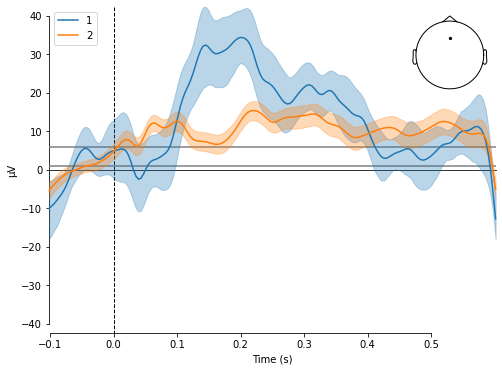

In [276]:
# fig = mne.viz.plot_compare_evokeds(
#     [list(evokeds[0]),list(evokeds[1])],
#     show=False,
#     ci=True,
# )

# axes = fig[0].axes

# axes[0].axhline(y=1, color='gray')
# axes[0].axhline(y=6, color='gray')

# # plt.axhline(y = 1*1e-6, color='gray', ls='--')

# plt.show()

## Extract features

#### Extract EEG features

In [32]:
class PeakToPeakBins(TransformerMixin, BaseEstimator):
    def __init__(self, zero_index=2):
        super().__init__()
        self.zero_index = zero_index # how many bins before zero the signal started
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
                
        peak_to_peaks = np.array(
            [
                np.array([[max(component[self.zero_index:-1]) - min(component[0:self.zero_index+1])] for component in participant])
                for participant in X
            ]
        )

        print(f"IN ERN min max RETURN SHAPE: {peak_to_peaks.shape}")
        return peak_to_peaks

In [33]:
class PeakToPeakBinsFourComponent(TransformerMixin, BaseEstimator):
    def __init__(self, zero_index=5):
        super().__init__()
        self.zero_index = zero_index # how many bins before zero the signal started
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        X_out = []
        
        for participant in X:
            component_0 = participant[0]
            component_1 = participant[1]
            component_2 = participant[2]
            component_3 = participant[3]
            
            component_0_ptp = np.array([max(component_0[1:self.zero_index+1]) - min(component_0[self.zero_index-1:-1])])
            component_2_ptp = np.array([max(component_2[self.zero_index-1:-1]) - min(component_2[1:self.zero_index+1])])
            
            peak_to_peaks = np.array([component_0_ptp, component_2_ptp])
            
            X_out.append(peak_to_peaks)
        
        X_out = np.array(X_out)

        print(f"IN 4 COMP PTP RETURN SHAPE: {X_out.shape}")
        return X_out

 1. ICA (Fast ICA)
 
 - ROI
 - time window: -100 to 200 ms
 - ICA(n=4)
 - binning: 24ms (6 tp)
 - peak-to-peak amplitude

In [34]:
timepoints_count = 78
spatial_filter_components = 4
bin_width = 6
# roi = ["Fpz", "AFz", "F3", "F1", "Fz", "F2", "F4", "FC3", "FC1", "FCz", "FC2", "FC4", "C3", "C1","Cz", "C2", "C4",]
roi = ["F3", "F1", "Fz", "F2", "F4", "FC3", "FC1", "FCz", "FC2", "FC4", "C3", "C1","Cz", "C2", "C4", "CP3", "CP1", "CPz", "CP2", "CP4"] # to 

In [35]:
test

False

In [36]:
if test:
    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    preprocessed_X_PCA_6bins = pipeline_ICA.transform(epochs_df_copy)
    preprocessed_X_PCA_6bins = preprocessed_X_PCA_6bins.reshape(preprocessed_X_PCA_6bins.shape[0], -1)
    
else:
    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

    pipeline_ICA = Pipeline([
        ("channels_extraction",PickChannels(channels_list=roi)),
        ("trim", EpochTrim(tmin=-0.1, tmax=0.20)),
        ("average", Evoked()),
        ('extract_averaged_data', ExtractData()),
        ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
        ("spatial_filter",FastICA(n_components=spatial_filter_components, random_state=random_state)),
        ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=timepoints_count)),
        ("lowpass_filter", LowpassFilter()),
        ("binning", BinTransformer(step=6)),
        # ("centering", CenteredSignalAfterBaseline_this2()),
        # ("ern_data_extraction", ErnTransformer(stop_ern_bin=6)),
        ("peak-to-peak", PeakToPeakBinsFourComponent(5)),
    ]).fit(epochs_df_copy)

    preprocessed_X_PCA_6bins = pipeline_ICA.transform(epochs_df_copy)

    preprocessed_X_PCA_6bins = preprocessed_X_PCA_6bins.reshape(preprocessed_X_PCA_6bins.shape[0], -1)

(260, 20, 78)
(260, 20, 78)
IN 4 COMP PTP RETURN SHAPE: (260, 2, 1)


In [37]:
preprocessed_X_PCA_6bins.shape

(260, 2)

2. ERN

- ROI: Fz
- time window: 0 - 100 ms
- mean amplitude

In [38]:
roi = [
    "Fz", 
]

In [39]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

ern_pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=0, tmax=0.1)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("mean_amplitude", AverageSignal()),
    
]).fit(epochs_df_copy)

preprocessed_X_ern = ern_pipeline.transform(epochs_df_copy)
preprocessed_X_ern = preprocessed_X_ern.reshape(preprocessed_X_ern.shape[0], -1)

(260, 1, 27)
(260, 1, 27)


In [40]:
preprocessed_X_ern.shape

(260, 1)

3. CRN

- ROI: Fz
- time window: 0 - 100 ms
- mean amplitude

In [41]:
roi = [
    "Fz", 
]

In [42]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

crn_pipeline = Pipeline([
   ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=0, tmax=0.1)),
    ("average", Evoked(condition='correct_response')),
    ('extract_averaged_data', ExtractData()),
    ("mean_amplitude", AverageSignal()),
    
]).fit(epochs_df_copy)

preprocessed_X_crn = crn_pipeline.transform(epochs_df_copy)
preprocessed_X_crn = preprocessed_X_crn.reshape(preprocessed_X_crn.shape[0], -1)

(260, 1, 27)
(260, 1, 27)


In [43]:
preprocessed_X_crn.shape

(260, 1)

4. ERN lateralization of peak

- ROI
- time window: 0 - 100 ms
- mean amplitude

In [44]:
def get_channels_with_peaks(evoked, roi):
    '''
    todo
    '''
    data = evoked.get_data()
    
    ch_min = 'Fpz'
    amp_min = 200
    for channel_index, channel in enumerate(roi):
        # plt.plot(np.arange(0, 27), data[channel_index])
        if min(data[channel_index]) < amp_min:
            amp_min = min(data[channel_index])
            ch_min = channel
    return ch_min, amp_min

In [45]:
def get_channels_with_maximal_signal(evoked, roi):
    '''
    todo
    '''
    data = evoked.get_data()
    
    ch_min = 'Fpz'
    amp_min = 200
    for channel_index, channel in enumerate(roi):
        # plt.plot(np.arange(0, 27), data[channel_index])
        if (data[channel_index]).mean() < amp_min:
            amp_min = data[channel_index].mean()
            ch_min = channel
    return ch_min, amp_min

In [46]:
# define channels for maximal signal search
roi = [
    "Fpz", 
    "AFz",
    "F3", "Fz", "F4",
    "FC3", "FCz", "FC4",
]

In [47]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict())) # if use peak, signal must be filtered with strong (e.g. 10 Hz) lowpass

In [48]:
tmin, tmax = 0.0, 0.08
channels_type_peak_ern = []
channels_type_mean_ern = []

X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
    ("average", Evoked(condition='error_response')),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

######
for subject in X:
    ch, amp = get_channels_with_peaks(subject[0], roi)
    ch_m, amp_m = get_channels_with_maximal_signal(subject[0], roi)
    # print(f"Channel {ch}\n Amplitude {amp}")
    channels_type_peak_ern.append(ch)
    channels_type_mean_ern.append(ch_m)
    
# change names of channels to: 0 = midline ; 1 = not midline (left or right)
channels_type_peak_ern = list(map(lambda x: 0 if x[-1] == 'z' else 1, channels_type_peak_ern))
channels_type_peak_ern = np.array(channels_type_peak_ern).reshape(len(channels_type_peak_ern), -1)    

channels_type_mean_ern = list(map(lambda x: 0 if x[-1] == 'z' else 1, channels_type_mean_ern))
channels_type_mean_ern = np.array(channels_type_mean_ern).reshape(len(channels_type_mean_ern), -1) 

channels_type_ern_peak = channels_type_peak_ern
channels_type_ern_mean = channels_type_mean_ern

In [49]:
channels_type_ern = channels_type_ern_mean
channels_type_ern.shape

(260, 1)

5. CRN lateralization of peak

- ROI
- time window: 0 - 100 ms
- mean amplitude

In [50]:
roi = [
    "Fpz", 
    "AFz",
    "F3", "Fz", "F4",
    "FC3", "FCz", "FC4",
]

In [51]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

In [52]:
tmin, tmax = 0.02, 0.08
peaks_crn = []
channels_type_peak_crn = []
channels_type_mean_crn = []

X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
    ("average", Evoked(condition='correct_response')),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

######
for subject in X:
    ch, amp = get_channels_with_peaks(subject[0], roi)
    ch_m, amp_m = get_channels_with_maximal_signal(subject[0], roi)
    # print(f"Channel {ch}\n Amplitude {amp}")
    channels_type_peak_crn.append(ch)
    channels_type_mean_crn.append(ch_m)

# change names of channels to: 0 = midline ; 1 = not midline (left or right)
channels_type_peak_crn = list(map(lambda x: 0 if x[-1] == 'z' else 1, channels_type_peak_crn))
channels_type_peak_crn = np.array(channels_type_peak_crn).reshape(len(channels_type_peak_crn), -1) 

channels_type_mean_crn = list(map(lambda x: 0 if x[-1] == 'z' else 1, channels_type_mean_crn))
channels_type_mean_crn = np.array(channels_type_mean_crn).reshape(len(channels_type_mean_crn), -1)   

channels_type_crn_peak = channels_type_peak_crn
channels_type_crn_mean = channels_type_mean_crn

In [53]:
channels_type_crn = channels_type_crn_mean
channels_type_crn.shape

(260, 1)

6. ERN latency

**1. Fractional area latency**

In [54]:
def fractional_negative_area_latency(evoked, fraction=0.5, tmin=0.0, tmax=0.5, threshold = 0.0):
    subject_data = evoked.get_data()
    x = np.linspace(tmin, tmax, subject_data.shape[-1])
    # print(x)
    y = subject_data.flatten()
    
    # get only negative part of signal
    y_negative = [abs(y_item) if y_item < threshold else 0 for y_item in y]
    
    # calculate area under the signal
    area = abs(simpson(y_negative, x))
    
    if area != 0.0:
        fractional_area = area * fraction
    
        # search for latency point (x) which split area according to fraction provided 
        current_area = 0
        fractional_area_index = 0
        i = 2
        while abs(simpson(y_negative[:i], x[:i])) <= fractional_area:
            current_area = abs(simpson(y_negative[:i], x[:i]))
            fractional_area_index = i
            i+=1
            
        # print(f'{fractional_area_index}; {x[fractional_area_index]}')
        # print(x)
        
        return (fractional_area_index, x[fractional_area_index])    
    else:
        print('No area detected')
        return (None, None) 

Parameters

In [55]:
roi = ['Fz']
tmin = -0.05
tmax = 0.2
threshold = 1*1e-6

Estimate fractional area latency

In [56]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

In [57]:
X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
    ("average", Evoked(condition='error_response')),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

In [58]:
fractional_latencies = []
for i in range(0, len(X)):        
    subject = X[i][0]
    evoked = subject
    # print(f"Index: {i}")
    this_latency = fractional_negative_area_latency(evoked, fraction=0.5, tmin=tmin, tmax=tmax, threshold=threshold)
    fractional_latencies.append(this_latency)

In [59]:
fractional_latencies_ern = list(map(lambda x: x[1] ,fractional_latencies))
fractional_latencies_ern = np.array(fractional_latencies_ern).reshape(-1,1)
fractional_latencies_ern.shape

(260, 1)

Test

In [60]:
# roi = ['Fz']
# tmin = -0.05
# tmax = 0.2

# epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

# X = Pipeline([
#     ("channels_extraction",PickChannels(channels_list=roi)),
#     ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
#     ("average", Evoked(condition='error_response')),
# ]).fit_transform(epochs_df_copy)

# X = X[['evoked']].to_numpy()

# for index in range(0, len(X)):
#     plt.figure(index)
    
#     subject_data = X[index][0].get_data()
#     x = np.linspace(tmin, tmax, subject_data.shape[-1])
#     y = subject_data.flatten()
#     # print(f"Index: {i}")
    
#     y_negative = [abs(y_item) if y_item < 0.1*1e-5 else 0 for y_item in y]
#     # calculate area under the signal
#     area = abs(simpson(y_negative,x))
#     fractional_area = area * 0.5
    
#     if fractional_area != 0:
#         # search for latency point (x) which split area according to fraction provided 
#         current_area = 0
#         fractional_area_index = 0
#         i = 2
#         if area != 0.0:
#             while abs(simpson(y_negative[:i], x[:i])) <= fractional_area:
#                 current_area = abs(simpson(y_negative[:i], x[:i]))
#                 fractional_area_index = i
#                 i+=1

#         plt.plot(x,y)
#         plt.plot(x, y_negative)
#         plt.axvline(x=x[fractional_area_index])
#     else:
#         fractional_area_index = 0
#         plt.plot(x,y)
#         plt.axvline(x=x[fractional_area_index], color='yellow')

**2. Peak Latency**

In [55]:
def peak_latency(evoked, tmin=0.0, tmax=0.5, ignore_peaks_before=0.0, favour_peaks_after = 0.0, ):
    '''
    Most negative peak
    '''
    subject_data = evoked.get_data()
    x = np.linspace(tmin, tmax, subject_data.shape[-1]) * 100
    y = subject_data.flatten()

    y_spl = UnivariateSpline(x,y,s=0,k=4)
    y_spl_1d = y_spl.derivative(n=1) # funkcja 1 pochodnej

    x_range = np.linspace(x[0],x[-1],1000)

    zeros = y_spl_1d.roots() # first derrivate zero -> peak

    personal_peaks = []
    lower_peak_x = 0
    step  = 0.6

    if len(zeros) > 0:
        for zero in zeros:
            if (zero > ignore_peaks_before*100):
                lower_peak_x = zero 
                personal_peaks.append((lower_peak_x, y_spl(lower_peak_x)))

        if len(personal_peaks) > 0:
            min_index = np.argmin(personal_peaks, axis=0)[-1]
            latency_value = personal_peaks[min_index][0]

            while latency_value < favour_peaks_after and len(personal_peaks) > 1:
                personal_peaks.pop(min_index)
                min_index = np.argmin(personal_peaks, axis=0)[-1]
                latency_value = personal_peaks[min_index][0]   
        else:
            latency_value = None 
    else:
        latency_value = None
        
    return latency_value

Lowpass data at 25 Hz for peak finding

In [1008]:
lowpass = 25.0

epochs_df_to_filter = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

epochs_filtered = Pipeline([
    ("lowpass", BandpassFilter(h_freq=lowpass)),
]).fit_transform(epochs_df_to_filter)

Parameters

In [1009]:
tmin = -0.05 # window start time
tmax = 0.12 # window stop time || peak search stop time
ignore_peaks_before = -0.025 # peak serach start time
roi = ['Fz']

Estimate peak latency

In [1010]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_filtered.to_dict()))

In [1011]:
X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
    ("average", Evoked(condition='error_response')),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

In [1012]:
peak_latencies = []
for i in range(0, len(X)):        
    subject = X[i][0]
    evoked = subject
    # print(f"Index: {i}")
    this_latency = peak_latency(evoked, tmin=tmin, tmax=tmax, ignore_peaks_before=ignore_peaks_before, favour_peaks_after=0.0)
    peak_latencies.append(this_latency)

In [1013]:
peak_latencies_ern = np.array(peak_latencies).reshape(-1,1)
peak_latencies_ern.shape

(260, 1)

Test

In [1014]:
# lowpass = 20.0

# epochs_df_to_filter = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

# epochs_filtered = Pipeline([
#     ("lowpass", BandpassFilter(h_freq=lowpass)),
# ]).fit_transform(epochs_df_to_filter)

In [1015]:
# tmin = -0.05 # window start time
# tmax = 0.12 # window stop time || peak search stop time
# ignore_peaks_before = -0.025 # peak serach start time

# roi = ['Fz']

# epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_filtered.to_dict()))

# X = Pipeline([
#     ("channels_extraction",PickChannels(channels_list=roi)),
#     ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
#     ("average", Evoked(condition='error_response')),
# ]).fit_transform(epochs_df_copy)

# X = X[['evoked']].to_numpy()

# peaks = []
# most_negative_peaks = []

# for index in range(0, len(X)):
#     plt.figure(index)
    
#     subject_data = X[index][0].get_data()
    
#     x = np.linspace(tmin, tmax, subject_data.shape[-1]) * 100
#     y = subject_data.flatten()
    
#     y_spl = UnivariateSpline(x,y,s=0,k=4)
#     y_spl_1d = y_spl.derivative(n=1) # funkcja 1 pochodnej

#     x_range = np.linspace(x[0],x[-1],1000)
    
#     plt.plot(x_range,y_spl(x_range)) # funkcja
#     plt.plot(x_range,y_spl_1d(x_range)) # 1 pochodna
#     plt.axhline(y = 0.0, color='gray') # zero
#     plt.axvline(x = 0.0, color='gray', ls='--') # zero
#     plt.text(0,0,i)

#     zeros = y_spl_1d.roots() # first derrivate zero -> peak

#     plt.scatter(x=zeros, y=[0]*len(zeros))

#     # define THIS peak
    
#     personal_peaks = []
#     lower_peak_x = 0
#     # max_lower_value = 2000
#     step  = 0.6

#     for zero in zeros:
#         if (zero > ignore_peaks_before*100):
#             lower_peak_x = zero 
#             personal_peaks.append((lower_peak_x, y_spl(lower_peak_x)))
#         # max_lower_value = y_spl(zero) if y_spl(zero) < max_lower_value and (zero > ignore_peaks_before*100) else max_lower_value
#     peaks.append(personal_peaks) 
#         # if y_spl(zero) < max_lower_value and zero > -2.5:
#     for index_2, erns in enumerate(personal_peaks):
#         x_ = erns[0]
#         plt.scatter(x=x_, y=[0]*len([x_]), color='red')
        
#     peaks_ = peaks.copy()

#     peak_latency = []
#     for person in peaks_:
#         min_index = np.argmin(person, axis=0)[-1]
#         latency_value = person[min_index][0]

#         while latency_value < 0 and len(person) > 1:
#             person.pop(min_index)
#             min_index = np.argmin(person, axis=0)[-1]
#             latency_value = person[min_index][0]    
#     plt.scatter(x=latency_value, y=[0]*len([latency_value]), color='purple')

In [1016]:
# peaks_ = peaks.copy()
# peak_latency = []

# for person in peaks_:
#     min_index = np.argmin(person, axis=0)[-1]
#     latency_value = person[min_index][0]

#     while latency_value < 0 and len(person) > 1:
#         person.pop(min_index)
#         min_index = np.argmin(person, axis=0)[-1]
#         latency_value = person[min_index][0]

#     peak_latency.append(latency_value)

In [1017]:
# np.array(peak_latency).reshape(-1,1).shape

---

CRN

**1. Fractional Area Latency**

Parameters: threshold at $2 \mu V$

In [61]:
roi = ['Fz']
tmin = -0.05
tmax = 0.2
threshold = 2*1e-6 # przy tym thresholdzie nie lapiemy wszystkich osob 1= 7 os; 2 = wszyscy

Estimate fractional area latency

In [62]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

In [63]:
X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
    ("average", Evoked(condition='correct_response')),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

In [64]:
fractional_latencies = []
for i in range(0, len(X)):        
    subject = X[i][0]
    evoked = subject
    # print(f"Index: {i}")
    this_latency = fractional_negative_area_latency(evoked, fraction=0.5, tmin=tmin, tmax=tmax, threshold=threshold)
    fractional_latencies.append(this_latency)

In [65]:
fractional_latencies_crn_2uV = list(map(lambda x: x[1] ,fractional_latencies))
fractional_latencies_crn_2uV = np.array(fractional_latencies_crn_2uV).reshape(-1,1)
fractional_latencies_crn_2uV.shape

(260, 1)

Parameters: threshold at $6 \mu V$

In [1023]:
roi = ['Fz']
tmin = -0.05
tmax = 0.2
threshold = 6*1e-6 # przy tym thresholdzie nie lapiemy wszystkich osob 1= 7 os; 2 = wszyscy

Estimate fractional area latency

In [1024]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

In [1025]:
X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
    ("average", Evoked(condition='correct_response')),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

In [1026]:
fractional_latencies = []
for i in range(0, len(X)):        
    subject = X[i][0]
    evoked = subject
    # print(f"Index: {i}")
    this_latency = fractional_negative_area_latency(evoked, fraction=0.5, tmin=tmin, tmax=tmax, threshold=threshold)
    fractional_latencies.append(this_latency)

In [1027]:
fractional_latencies_crn_6uV = list(map(lambda x: x[1] ,fractional_latencies))
fractional_latencies_crn_6uV = np.array(fractional_latencies_crn_6uV).reshape(-1,1)
fractional_latencies_crn_6uV.shape

(260, 1)

Test

In [ ]:
# roi = ['Fz']
# # tmin = -0.02
# # tmax = 0.065
# tmin = -0.05
# tmax = 0.2
# threshold = 2*1e-6
# # threshold = 0

# epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

# X = Pipeline([
#     ("channels_extraction",PickChannels(channels_list=roi)),
#     ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
#     ("average", Evoked(condition='correct_response')),
# ]).fit_transform(epochs_df_copy)

# X = X[['evoked']].to_numpy()

# for index in range(0, len(X)):
#     plt.figure(index)
    
#     subject_data = X[index][0].get_data()
#     x = np.linspace(tmin, tmax, subject_data.shape[-1])
#     y = subject_data.flatten()
#     # print(f"Index: {i}")
    
#     y_negative = [abs(y_item) if y_item < threshold else 0 for y_item in y]
#     # calculate area under the signal
#     area = abs(simpson(y_negative,x))
#     fractional_area = area * 0.5
    
#     if fractional_area != 0:
#         # search for latency point (x) which split area according to fraction provided 
#         current_area = 0
#         fractional_area_index = 0
#         i = 2
#         if area != 0.0:
#             while abs(simpson(y_negative[:i], x[:i])) <= fractional_area:
#                 current_area = abs(simpson(y_negative[:i], x[:i]))
#                 fractional_area_index = i
#                 i+=1

#         plt.plot(x,y)
#         plt.plot(x, y_negative)
#         plt.axvline(x=x[fractional_area_index])
#     else:
#         fractional_area_index = 0
#         plt.plot(x,y)
#         plt.axvline(x=x[fractional_area_index], color='yellow')

**2. Peak Latency**

Lowpass data at 25 Hz for peak finding

In [1029]:
lowpass = 25.0

epochs_df_to_filter = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

epochs_filtered = Pipeline([
    ("lowpass", BandpassFilter(h_freq=lowpass)),
]).fit_transform(epochs_df_to_filter)

Parameters

In [1030]:
tmin = -0.05 # window start time
tmax = 0.10 # window stop time || peak search stop time
ignore_peaks_before = -0.025 # peak serach start time
roi = ['Fz']

Estimate peak latency

In [1031]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_filtered.to_dict()))

In [1032]:
X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
    ("average", Evoked(condition='correct_response')),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

In [1033]:
peak_latencies = []
for i in range(0, len(X)):        
    subject = X[i][0]
    evoked = subject
    # print(f"Index: {i}")
    this_latency = peak_latency(evoked, tmin=tmin, tmax=tmax, ignore_peaks_before=ignore_peaks_before, favour_peaks_after=-0.025)
    peak_latencies.append(this_latency)

In [1034]:
peak_latencies_crn = np.array(peak_latencies).reshape(-1,1)
peak_latencies_crn.shape

(260, 1)

Test

In [1035]:
# tmin = -0.05 # window start time
# tmax = 0.10 # window stop time || peak search stop time
# ignore_peaks_before = -0.025 # peak serach start time

# roi = ['Fz']

# epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_filtered.to_dict()))

# X = Pipeline([
#     ("channels_extraction",PickChannels(channels_list=roi)),
#     ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
#     ("average", Evoked(condition='correct_response')),
# ]).fit_transform(epochs_df_copy)

# X = X[['evoked']].to_numpy()

# peaks = []
# most_negative_peaks = []

# for index in range(0, len(X)):
#     plt.figure(index)
    
#     subject_data = X[index][0].get_data()
    
#     x = np.linspace(tmin, tmax, subject_data.shape[-1]) * 100
#     y = subject_data.flatten()
    
#     y_spl = UnivariateSpline(x,y,s=0,k=4)
#     y_spl_1d = y_spl.derivative(n=1) # funkcja 1 pochodnej

#     x_range = np.linspace(x[0],x[-1],1000)
    
#     plt.plot(x_range,y_spl(x_range)) # funkcja
#     plt.plot(x_range,y_spl_1d(x_range)) # 1 pochodna
#     plt.axhline(y = 0.0, color='gray') # zero
#     plt.axvline(x = 0.0, color='gray', ls='--') # zero
#     plt.text(0,0,index)

#     zeros = y_spl_1d.roots() # first derrivate zero -> peak

#     plt.scatter(x=zeros, y=[0]*len(zeros))

#     # define THIS peak
    
#     personal_peaks = []
#     lower_peak_x = 0
#     # max_lower_value = 2000
#     step  = 0.6
    
#     if len(zeros) != 0:

#         for zero in zeros:
#             if (zero > ignore_peaks_before*100):
#                 lower_peak_x = zero 
#                 personal_peaks.append((lower_peak_x, y_spl(lower_peak_x)))
#             # max_lower_value = y_spl(zero) if y_spl(zero) < max_lower_value and (zero > ignore_peaks_before*100) else max_lower_value

#             # if y_spl(zero) < max_lower_value and zero > -2.5:
#         for index_2, erns in enumerate(personal_peaks):
#             x_ = erns[0]
#             plt.scatter(x=x_, y=[0]*len([x_]), color='red')

#         peaks_ = personal_peaks.copy()

#         if len(peaks_) > 0:
#             min_index = np.argmin(peaks_, axis=0)[-1]
#             latency_value = peaks_[min_index][0]

#             while latency_value < ignore_peaks_before*100 and len(peaks_) > 1:
#                 peaks_.pop(min_index)
#                 min_index = np.argmin(peaks_, axis=0)[-1]
#                 latency_value = peaks_[min_index][0]    
            
#             plt.scatter(x=latency_value, y=[0]*len([latency_value]), color='purple')

#         else:
#             for zero in zeros:
#                 plt.scatter(x=zero, y=[0]*len([zero]), color='green')
#     else:
#         plt.scatter(x=0, y=[0]*len([0]), color='yellow')

---

#### Extract anxiety-related questionnaires scores

Questionnaires to include in analysis

In [66]:
rumination = "RRQ"
dass_anxiety = "DASS-21 Anx"
dass_stress = "DASS-21 Stress"
dass_dep = "DASS-21 Dep"
stai_t = "STAI-T" 
bis = "BIS"
bas_dzialanie = "BAS_D"
bas_przyjemnosc = "BAS_PRZY"
bas_nagroda = "BAS_NAG"
washing = "WASH"
obsessing = "OBSESS"
hoarding = "HOARD"
ordering = "ORD"
checking = "CHECK"
neutralizing = "NEU"
oci_r_full = "OCI-R"
threat = "OT"
thought_suppression = "WBSI"
indecisivness = "INDEC_F"
IU_prospecitve = "IUS-P"
IU_inhibitory = "IUS-I"
self_esteem = "SES"
punishment_sensitivity = "PUN"
reward_sensitivity = "REW"
harm_responsibility = "HARM"
thought_control = "T-CTR"
perfectionism_IU = "OB_PERF"
# perfectionism_cmda = "17-Perfectionism CMDA"
perfectionism_ps = "PS"
guilt_sensitivity = "G_SE"
intolerance_ambiguity = "AMB"
predictability = "PRED"
high_standards = "STAND"

In [67]:
scales = [
    rumination,
    # dass_anxiety,
    dass_stress,
    dass_dep,
    stai_t,
    bis,
    bas_dzialanie,
    bas_przyjemnosc,
    bas_nagroda,
    washing,
    obsessing,
    hoarding,
    ordering,
    checking,
    neutralizing,
    # oci_r_full,
    threat,
    thought_suppression,
    indecisivness,
    punishment_sensitivity,
    reward_sensitivity,
    harm_responsibility,
    guilt_sensitivity,
    thought_control,
    perfectionism_IU,
    # perfectionism_cmda,
    perfectionism_ps,
    intolerance_ambiguity,
    predictability,
    high_standards,
    IU_prospecitve,
    IU_inhibitory,
    self_esteem,
]

In [68]:
questionnaires_scores_df = epochs_df[scales]
questionnaires_scores_df

,RRQ,DASS-21 Stress,DASS-21 Dep,STAI-T,BIS,BAS_D,BAS_PRZY,BAS_NAG,WASH,OBSESS,...,G_SE,T-CTR,OB_PERF,PS,AMB,PRED,STAND,IUS-P,IUS-I,SES
0,3.416667,1.285714,2.142857,2.25,2.90,1.75,2.50,3.0,1.666667,2.333333,...,3.0,4.0,4.0,1.428571,4.83,4.25,4.666667,3.142857,2.8,2.4
1,3.750000,1.142857,1.285714,2.00,2.70,2.00,3.50,2.6,2.000000,2.333333,...,3.0,1.6,2.6,2.714286,4.17,3.75,5.000000,2.714286,1.8,3.1
2,3.833333,1.857143,1.571429,2.40,3.10,1.50,2.50,2.6,1.000000,1.333333,...,2.2,1.8,3.2,3.285714,4.00,4.25,4.333333,2.142857,3.0,2.4
3,2.250000,3.000000,2.571429,2.80,3.00,2.50,2.50,2.8,1.000000,1.333333,...,2.8,1.2,2.0,3.428571,3.33,3.00,4.000000,3.428571,3.2,2.7
4,3.916667,2.142857,1.571429,2.25,3.00,3.00,3.75,3.0,1.333333,2.666667,...,3.0,2.0,1.8,2.285714,3.67,3.25,4.000000,2.857143,1.8,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,4.580000,3.710000,3.140000,2.85,4.00,2.25,3.25,3.4,1.000000,5.000000,...,3.8,3.0,6.2,2.860000,4.83,4.88,6.330000,3.860000,4.8,2.3
256,3.250000,2.290000,2.000000,2.15,2.86,2.00,2.50,2.4,2.000000,2.000000,...,2.7,2.0,3.0,2.000000,3.33,3.50,3.000000,3.000000,2.2,2.7
257,4.670000,2.430000,2.570000,2.50,3.00,2.75,1.75,2.8,1.000000,2.330000,...,2.5,1.2,1.2,4.140000,5.00,3.88,5.000000,3.860000,3.0,1.9
258,2.750000,2.290000,2.570000,2.75,3.14,2.00,2.75,3.0,1.000000,1.000000,...,2.5,1.0,1.8,1.710000,5.50,4.75,2.330000,3.430000,3.8,1.8


In [69]:
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None):
    display(questionnaires_scores_df.describe())

,RRQ,DASS-21 Stress,DASS-21 Dep,STAI-T,BIS,BAS_D,BAS_PRZY,BAS_NAG,WASH,OBSESS,HOARD,ORD,CHECK,NEU,OT,WBSI,INDEC_F,PUN,REW,HARM,G_SE,T-CTR,OB_PERF,PS,AMB,PRED,STAND,IUS-P,IUS-I,SES
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,3.585500,2.272088,1.943247,2.277692,3.018346,2.392308,2.760577,3.191538,1.662603,2.543526,2.233487,2.482077,2.548654,1.496090,2.966154,3.556218,3.100051,6.165385,4.030769,3.953077,2.981154,2.498462,3.407692,3.059401,4.134000,3.693500,4.584577,3.124775,2.475385,2.802308
std,0.850932,0.653790,0.698709,0.469846,0.523086,0.627121,0.593671,0.425543,0.823587,1.091452,0.963780,1.077597,1.049201,0.644882,1.218427,0.806418,0.713536,3.570519,2.056869,1.005213,0.773743,0.985218,1.257172,0.938879,0.786534,0.893359,1.239791,0.780033,0.935533,0.630005
min,1.330000,1.000000,1.000000,1.250000,1.700000,1.000000,1.000000,2.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.266667,1.066667,0.000000,0.000000,1.000000,1.200000,1.000000,1.000000,1.000000,1.670000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,1.857143,1.428571,1.900000,2.700000,2.000000,2.500000,2.800000,1.000000,1.666667,1.333333,1.666667,1.669167,1.000000,2.000000,3.000000,2.600000,3.000000,2.000000,3.200000,2.475000,1.800000,2.400000,2.428571,3.627500,3.097500,3.670000,2.571429,1.800000,2.400000
50%,3.670000,2.285714,1.714286,2.250000,3.000000,2.250000,2.750000,3.200000,1.333333,2.333333,2.000000,2.333333,2.333333,1.330000,2.800000,3.600000,3.070000,6.000000,4.000000,4.000000,3.000000,2.300000,3.300000,3.000000,4.170000,3.750000,4.668333,3.141429,2.400000,2.800000
75%,4.330000,2.714286,2.428571,2.650000,3.400000,2.750000,3.250000,3.400000,2.000000,3.333333,3.000000,3.330000,3.333333,1.670000,3.800000,4.133333,3.666667,9.000000,6.000000,4.600000,3.500000,3.200000,4.400000,3.714286,4.670000,4.380000,5.333333,3.714286,3.200000,3.300000
max,5.000000,3.860000,4.000000,3.500000,4.000000,4.000000,4.000000,4.000000,4.670000,5.000000,5.000000,5.000000,5.000000,4.000000,6.200000,5.000000,4.600000,13.000000,8.000000,6.800000,4.900000,6.200000,6.800000,5.000000,6.000000,6.000000,7.000000,5.000000,4.800000,4.000000


Check skewness and kurtiosis

As a general rule of thumb: If skewness is less than -1 or greater than 1, the distribution is highly skewed. If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed. If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

Analogous to the skewness, the general guideline is that if the kurtosis is greater than +2, the distribution is too peaked. Likewise, a kurtosis of less than −2 indicates a distribution that is too flat. When both skewness and kurtosis are close to zero, the pattern of responses is considered a normal distribution 

In [70]:
summary = questionnaires_scores_df.agg(['skew', 'kurtosis', 'mean', 'std', 'min', 'max']).transpose()
summary

,skew,kurtosis,mean,std,min,max
RRQ,-0.422316,-0.623886,3.585500,0.850932,1.330000,5.00
DASS-21 Stress,0.248132,-0.492854,2.272088,0.653790,1.000000,3.86
DASS-21 Dep,0.802576,0.015942,1.943247,0.698709,1.000000,4.00
STAI-T,0.142289,-0.534881,2.277692,0.469846,1.250000,3.50
BIS,-0.003226,-0.619946,3.018346,0.523086,1.700000,4.00
BAS_D,0.359135,-0.136873,2.392308,0.627121,1.000000,4.00
BAS_PRZY,-0.327866,0.193784,2.760577,0.593671,1.000000,4.00
BAS_NAG,-0.063078,-0.528269,3.191538,0.425543,2.200000,4.00
WASH,1.485257,1.818988,1.662603,0.823587,1.000000,4.67
OBSESS,0.428625,-0.751382,2.543526,1.091452,1.000000,5.00


Transform entries with high skewness and kurtosis with BoxCox method

In [71]:
questionnaires_scores_df_transformed = questionnaires_scores_df.copy()

for row in summary.iterrows():
    item_name = row[0]
    skewness_ = row[1]['skew']
    kurtosis_ = row[1]['kurtosis']
    
    if abs(skewness_) > 1 or abs(kurtosis_) > 2:
        print(f'Transforming: {item_name} scale')
        this_scores = questionnaires_scores_df_transformed[[item_name]].to_numpy().flatten()
        this_scores = this_scores - 0.99
        this_scores_transformed, lambda_ = boxcox(this_scores)
        print(f'   Stats before transformation:\n    Skewness: {scipy.stats.skew(this_scores)} \n    Kurtosis: {scipy.stats.kurtosis(this_scores)}')
        print(f'   Stats after transformation:\n    Skewness: {scipy.stats.skew(this_scores_transformed)} \n    Kurtosis: {scipy.stats.kurtosis(this_scores_transformed)}')
        
        questionnaires_scores_df_transformed[[item_name]] = this_scores_transformed.reshape(-1,1)

Transforming: WASH scale
   Stats before transformation:
    Skewness: 1.4766744348474652 
    Kurtosis: 1.761206514533587
   Stats after transformation:
    Skewness: -0.14880225101247238 
    Kurtosis: -1.5962530625335125
Transforming: NEU scale
   Stats before transformation:
    Skewness: 1.4226481920860998 
    Kurtosis: 1.5127609844778966
   Stats after transformation:
    Skewness: -0.009417640513208118 
    Kurtosis: -1.8202331391457982


In [72]:
summary = questionnaires_scores_df_transformed.agg(['skew', 'kurtosis', 'mean', 'std', 'min', 'max']).transpose()
summary

,skew,kurtosis,mean,std,min,max
RRQ,-0.422316,-0.623886,3.585500,0.850932,1.330000,5.000000
DASS-21 Stress,0.248132,-0.492854,2.272088,0.653790,1.000000,3.860000
DASS-21 Dep,0.802576,0.015942,1.943247,0.698709,1.000000,4.000000
STAI-T,0.142289,-0.534881,2.277692,0.469846,1.250000,3.500000
BIS,-0.003226,-0.619946,3.018346,0.523086,1.700000,4.000000
BAS_D,0.359135,-0.136873,2.392308,0.627121,1.000000,4.000000
BAS_PRZY,-0.327866,0.193784,2.760577,0.593671,1.000000,4.000000
BAS_NAG,-0.063078,-0.528269,3.191538,0.425543,2.200000,4.000000
WASH,-0.149667,-1.603944,-1.452291,1.747292,-3.536578,1.410471
OBSESS,0.428625,-0.751382,2.543526,1.091452,1.000000,5.000000


#### Demographical data

In [73]:
age = "Age"
sex = "Sex"
handness = "Handness"

In [74]:
scales = [
    age,
    sex,
    handness
]

In [75]:
demographical_scores_df =  epochs_df[scales].astype(float)

In [76]:
summary = demographical_scores_df.agg(['skew', 'kurtosis', 'mean', 'std', 'min', 'max']).transpose()
summary

,skew,kurtosis,mean,std,min,max
Age,1.598050,3.273384,23.211538,3.983249,18.0,40.0
Sex,0.281242,-1.935854,0.430769,0.496139,0.0,1.0
Handness,-2.755702,5.637197,0.903846,0.295371,0.0,1.0


Transform skewed age entry

In [77]:
age = demographical_scores_df[['Age']].to_numpy().flatten()
age_transformed, lambda_ = boxcox(age)
demographical_scores_df[['Age']] = age_transformed.reshape(-1,1)

In [78]:
summary = demographical_scores_df.agg(['skew', 'kurtosis', 'mean', 'std', 'min', 'max']).transpose()
summary

,skew,kurtosis,mean,std,min,max
Age,0.060186,-0.382029,0.424995,0.000091,0.424806,0.425209
Sex,0.281242,-1.935854,0.430769,0.496139,0.000000,1.000000
Handness,-2.755702,5.637197,0.903846,0.295371,0.000000,1.000000


#### Concatenate questionnaire and EEG features

In [79]:
eeg_columns_ica = ['e_PCA_1_6', 'e_PCA_2_6']

eeg_columns_ern = ['e_ERN']
eeg_columns_crn = ['e_CRN']

eeg_column_latencies_fal = ['e_LT_F']
eeg_column_latencies_peak = ['e_LT_P']

eeg_column_ch_type = ['e_LTR']


eeg_column_latencies_fal_2_crn = ['e_LT_F2_C']
eeg_column_latencies_fal_6_crn = ['e_LT_F6_C']
eeg_column_latencies_peak_crn = ['e_LT_P_C']

eeg_column_ch_type_crn = ['e_LTR_C']

1. ERN model

In [80]:
dataset

'train'

In [81]:
results_ern_df = pd.DataFrame()

results_ern_df[eeg_columns_ern] = preprocessed_X_ern # simple mean amp of ERN in 0 -100 m
results_ern_df = pd.concat([results_ern_df, questionnaires_scores_df_transformed], axis=1) # add questionnaires

results_ern_df.to_pickle(f"../data/models_pickles_new_dass/ern_models_{dataset}.pkl")
results_ern_df.head()

,e_ERN,RRQ,DASS-21 Stress,DASS-21 Dep,STAI-T,BIS,BAS_D,BAS_PRZY,BAS_NAG,WASH,...,G_SE,T-CTR,OB_PERF,PS,AMB,PRED,STAND,IUS-P,IUS-I,SES
0,-6.622882e-07,3.416667,1.285714,2.142857,2.25,2.9,1.75,2.50,3.0,-0.381551,...,3.0,4.0,4.0,1.428571,4.83,4.25,4.666667,3.142857,2.8,2.4
1,-1.121127e-05,3.750000,1.142857,1.285714,2.00,2.7,2.00,3.50,2.6,0.009956,...,3.0,1.6,2.6,2.714286,4.17,3.75,5.000000,2.714286,1.8,3.1
2,-1.579851e-05,3.833333,1.857143,1.571429,2.40,3.1,1.50,2.50,2.6,-3.536578,...,2.2,1.8,3.2,3.285714,4.00,4.25,4.333333,2.142857,3.0,2.4
3,-5.217479e-07,2.250000,3.000000,2.571429,2.80,3.0,2.50,2.50,2.8,-3.536578,...,2.8,1.2,2.0,3.428571,3.33,3.00,4.000000,3.428571,3.2,2.7
4,-6.456946e-06,3.916667,2.142857,1.571429,2.25,3.0,3.00,3.75,3.0,-1.003221,...,3.0,2.0,1.8,2.285714,3.67,3.25,4.000000,2.857143,1.8,3.0


1' CRN model

In [82]:
results_crn_df = pd.DataFrame()

results_crn_df[eeg_columns_crn] = preprocessed_X_crn # simple mean amp of ERN in 0 -100 ms
results_crn_df = pd.concat([results_crn_df, questionnaires_scores_df_transformed], axis=1) # add questionnaires

results_crn_df.to_pickle(f"../data/models_pickles_new_dass/crn_models_{dataset}.pkl")
results_crn_df.head()

,e_CRN,RRQ,DASS-21 Stress,DASS-21 Dep,STAI-T,BIS,BAS_D,BAS_PRZY,BAS_NAG,WASH,...,G_SE,T-CTR,OB_PERF,PS,AMB,PRED,STAND,IUS-P,IUS-I,SES
0,-4.337408e-07,3.416667,1.285714,2.142857,2.25,2.9,1.75,2.50,3.0,-0.381551,...,3.0,4.0,4.0,1.428571,4.83,4.25,4.666667,3.142857,2.8,2.4
1,-2.552095e-06,3.750000,1.142857,1.285714,2.00,2.7,2.00,3.50,2.6,0.009956,...,3.0,1.6,2.6,2.714286,4.17,3.75,5.000000,2.714286,1.8,3.1
2,-8.552639e-06,3.833333,1.857143,1.571429,2.40,3.1,1.50,2.50,2.6,-3.536578,...,2.2,1.8,3.2,3.285714,4.00,4.25,4.333333,2.142857,3.0,2.4
3,4.879014e-06,2.250000,3.000000,2.571429,2.80,3.0,2.50,2.50,2.8,-3.536578,...,2.8,1.2,2.0,3.428571,3.33,3.00,4.000000,3.428571,3.2,2.7
4,-6.275722e-07,3.916667,2.142857,1.571429,2.25,3.0,3.00,3.75,3.0,-1.003221,...,3.0,2.0,1.8,2.285714,3.67,3.25,4.000000,2.857143,1.8,3.0


2. ERN, Fractional Area Latency, Lateralization + DEMO model

In [83]:
results_ern_lat_df = pd.DataFrame()

results_ern_lat_df[eeg_columns_ern] = preprocessed_X_ern # simple mean amp of ERN in 0 -100 ms
results_ern_lat_df[eeg_column_latencies_fal] = fractional_latencies_ern # latency of the largest amplitude within channels in ms
# results_ern_lat_df[eeg_column_ch_type] = channels_type_ern # the biggest peak on the central || left || right channels 
results_ern_lat_df = pd.concat([results_ern_lat_df, demographical_scores_df, questionnaires_scores_df_transformed], axis=1) # add questionnaires

results_ern_lat_df.to_pickle(f"../data/models_pickles_new_dass/ern_cov_fal_models_{dataset}.pkl")
results_ern_lat_df.head()

,e_ERN,e_LT_F,Age,Sex,Handness,RRQ,DASS-21 Stress,DASS-21 Dep,STAI-T,BIS,...,G_SE,T-CTR,OB_PERF,PS,AMB,PRED,STAND,IUS-P,IUS-I,SES
0,-6.622882e-07,0.082812,0.424951,1.0,1.0,3.416667,1.285714,2.142857,2.25,2.9,...,3.0,4.0,4.0,1.428571,4.83,4.25,4.666667,3.142857,2.8,2.4
1,-1.121127e-05,0.106250,0.424985,1.0,1.0,3.750000,1.142857,1.285714,2.00,2.7,...,3.0,1.6,2.6,2.714286,4.17,3.75,5.000000,2.714286,1.8,3.1
2,-1.579851e-05,0.063281,0.425040,1.0,1.0,3.833333,1.857143,1.571429,2.40,3.1,...,2.2,1.8,3.2,3.285714,4.00,4.25,4.333333,2.142857,3.0,2.4
3,-5.217479e-07,0.004687,0.425113,1.0,1.0,2.250000,3.000000,2.571429,2.80,3.0,...,2.8,1.2,2.0,3.428571,3.33,3.00,4.000000,3.428571,3.2,2.7
4,-6.456946e-06,0.059375,0.425062,1.0,1.0,3.916667,2.142857,1.571429,2.25,3.0,...,3.0,2.0,1.8,2.285714,3.67,3.25,4.000000,2.857143,1.8,3.0


2' CRN, Fractional Area Latency (2 uV), Lateralization + DEMO model

In [84]:
results_crn_lat_demo_df = pd.DataFrame()

results_crn_lat_demo_df[eeg_columns_crn] = preprocessed_X_crn # simple mean amp of ERN in 0 -100 ms
results_crn_lat_demo_df[eeg_column_latencies_fal_2_crn] = fractional_latencies_crn_2uV # latency of the largest amplitude within channels in ms
# results_crn_lat_demo_df[eeg_column_ch_type_crn] = channels_type_crn # the biggest peak on the central || left || right channels 
results_crn_lat_demo_df = pd.concat([results_crn_lat_demo_df, demographical_scores_df, questionnaires_scores_df_transformed], axis=1) # add questionnaires

results_crn_lat_demo_df.to_pickle(f"../data/models_pickles_new_dass/crn_cov_fal2_models_{dataset}.pkl")
results_crn_lat_demo_df.head()

,e_CRN,e_LT_F2_C,Age,Sex,Handness,RRQ,DASS-21 Stress,DASS-21 Dep,STAI-T,BIS,...,G_SE,T-CTR,OB_PERF,PS,AMB,PRED,STAND,IUS-P,IUS-I,SES
0,-4.337408e-07,0.133594,0.424951,1.0,1.0,3.416667,1.285714,2.142857,2.25,2.9,...,3.0,4.0,4.0,1.428571,4.83,4.25,4.666667,3.142857,2.8,2.4
1,-2.552095e-06,0.137500,0.424985,1.0,1.0,3.750000,1.142857,1.285714,2.00,2.7,...,3.0,1.6,2.6,2.714286,4.17,3.75,5.000000,2.714286,1.8,3.1
2,-8.552639e-06,0.098437,0.425040,1.0,1.0,3.833333,1.857143,1.571429,2.40,3.1,...,2.2,1.8,3.2,3.285714,4.00,4.25,4.333333,2.142857,3.0,2.4
3,4.879014e-06,-0.007031,0.425113,1.0,1.0,2.250000,3.000000,2.571429,2.80,3.0,...,2.8,1.2,2.0,3.428571,3.33,3.00,4.000000,3.428571,3.2,2.7
4,-6.275722e-07,0.043750,0.425062,1.0,1.0,3.916667,2.142857,1.571429,2.25,3.0,...,3.0,2.0,1.8,2.285714,3.67,3.25,4.000000,2.857143,1.8,3.0


2'' CRN, Fractional Area Latency (6 uV), Lateralization + DEMO model

In [1061]:
results_crn_lat_demo_df = pd.DataFrame()

results_crn_lat_demo_df[eeg_columns_crn] = preprocessed_X_crn # simple mean amp of ERN in 0 -100 ms
results_crn_lat_demo_df[eeg_column_latencies_fal_6_crn] = fractional_latencies_crn_6uV # latency of the largest amplitude within channels in ms
# results_crn_lat_demo_df[eeg_column_ch_type_crn] = channels_type_crn # the biggest peak on the central || left || right channels 
results_crn_lat_demo_df = pd.concat([results_crn_lat_demo_df, demographical_scores_df, questionnaires_scores_df_transformed], axis=1) # add questionnaires

results_crn_lat_demo_df.to_pickle(f"../data/models_pickles_new/crn_cov_fal6_models_{dataset}.pkl")
results_crn_lat_demo_df.head()

,e_CRN,e_LT_F6_C,Age,Sex,Handness,RRQ,STAI-T,BIS,BAS_D,BAS_PRZY,...,G_SE,T-CTR,OB_PERF,PS,AMB,PRED,STAND,IUS-P,IUS-I,SES
0,-4.337408e-07,0.129688,0.424951,1.0,1.0,3.416667,45,2.9,1.75,2.50,...,3.0,4.0,4.0,1.428571,4.83,4.25,4.666667,3.142857,2.8,2.4
1,-2.552095e-06,0.137500,0.424985,1.0,1.0,3.750000,40,2.7,2.00,3.50,...,3.0,1.6,2.6,2.714286,4.17,3.75,5.000000,2.714286,1.8,3.1
2,-8.552639e-06,0.098437,0.425040,1.0,1.0,3.833333,48,3.1,1.50,2.50,...,2.2,1.8,3.2,3.285714,4.00,4.25,4.333333,2.142857,3.0,2.4
3,4.879014e-06,0.102344,0.425113,1.0,1.0,2.250000,56,3.0,2.50,2.50,...,2.8,1.2,2.0,3.428571,3.33,3.00,4.000000,3.428571,3.2,2.7
4,-6.275722e-07,0.106250,0.425062,1.0,1.0,3.916667,45,3.0,3.00,3.75,...,3.0,2.0,1.8,2.285714,3.67,3.25,4.000000,2.857143,1.8,3.0


3.ERN, Peak Latency, Lateralization + DEMO model

In [1062]:
results_ern_lat_df = pd.DataFrame()

results_ern_lat_df[eeg_columns_ern] = preprocessed_X_ern # simple mean amp of ERN in 0 -100 ms
results_ern_lat_df[eeg_column_latencies_peak] = peak_latencies_ern # latency of the largest amplitude within channels in ms
# results_ern_lat_df[eeg_column_ch_type] = channels_type_ern # the biggest peak on the central || left || right channels 
results_ern_lat_df = pd.concat([results_ern_lat_df, demographical_scores_df, questionnaires_scores_df_transformed], axis=1) # add questionnaires

results_ern_lat_df.to_pickle(f"../data/models_pickles_new/ern_cov_peak_models_{dataset}.pkl")
results_ern_lat_df.head()

,e_ERN,e_LT_P,Age,Sex,Handness,RRQ,STAI-T,BIS,BAS_D,BAS_PRZY,...,G_SE,T-CTR,OB_PERF,PS,AMB,PRED,STAND,IUS-P,IUS-I,SES
0,-6.622882e-07,8.416593,0.424951,1.0,1.0,3.416667,45,2.9,1.75,2.50,...,3.0,4.0,4.0,1.428571,4.83,4.25,4.666667,3.142857,2.8,2.4
1,-1.121127e-05,9.724629,0.424985,1.0,1.0,3.750000,40,2.7,2.00,3.50,...,3.0,1.6,2.6,2.714286,4.17,3.75,5.000000,2.714286,1.8,3.1
2,-1.579851e-05,5.339004,0.425040,1.0,1.0,3.833333,48,3.1,1.50,2.50,...,2.2,1.8,3.2,3.285714,4.00,4.25,4.333333,2.142857,3.0,2.4
3,-5.217479e-07,0.096865,0.425113,1.0,1.0,2.250000,56,3.0,2.50,2.50,...,2.8,1.2,2.0,3.428571,3.33,3.00,4.000000,3.428571,3.2,2.7
4,-6.456946e-06,4.959093,0.425062,1.0,1.0,3.916667,45,3.0,3.00,3.75,...,3.0,2.0,1.8,2.285714,3.67,3.25,4.000000,2.857143,1.8,3.0


3'. CRN, Peak Latency, Lateralization + DEMO model

In [1063]:
results_crn_lat_demo_df = pd.DataFrame()

results_crn_lat_demo_df[eeg_columns_crn] = preprocessed_X_crn # simple mean amp of ERN in 0 -100 ms
results_crn_lat_demo_df[eeg_column_latencies_peak_crn] = peak_latencies_crn # latency of the largest amplitude within channels in ms
# results_crn_lat_demo_df[eeg_column_ch_type_crn] = channels_type_crn # the biggest peak on the central || left || right channels 
results_crn_lat_demo_df = pd.concat([results_crn_lat_demo_df, demographical_scores_df, questionnaires_scores_df_transformed], axis=1) # add questionnaires

results_crn_lat_demo_df.to_pickle(f"../data/models_pickles_new/crn_cov_peak_models_{dataset}.pkl")
results_crn_lat_demo_df.head()

,e_CRN,e_LT_P_C,Age,Sex,Handness,RRQ,STAI-T,BIS,BAS_D,BAS_PRZY,...,G_SE,T-CTR,OB_PERF,PS,AMB,PRED,STAND,IUS-P,IUS-I,SES
0,-4.337408e-07,3.622315,0.424951,1.0,1.0,3.416667,45,2.9,1.75,2.50,...,3.0,4.0,4.0,1.428571,4.83,4.25,4.666667,3.142857,2.8,2.4
1,-2.552095e-06,0.90916,0.424985,1.0,1.0,3.750000,40,2.7,2.00,3.50,...,3.0,1.6,2.6,2.714286,4.17,3.75,5.000000,2.714286,1.8,3.1
2,-8.552639e-06,4.29846,0.425040,1.0,1.0,3.833333,48,3.1,1.50,2.50,...,2.2,1.8,3.2,3.285714,4.00,4.25,4.333333,2.142857,3.0,2.4
3,4.879014e-06,5.08056,0.425113,1.0,1.0,2.250000,56,3.0,2.50,2.50,...,2.8,1.2,2.0,3.428571,3.33,3.00,4.000000,3.428571,3.2,2.7
4,-6.275722e-07,4.110984,0.425062,1.0,1.0,3.916667,45,3.0,3.00,3.75,...,3.0,2.0,1.8,2.285714,3.67,3.25,4.000000,2.857143,1.8,3.0


----
## Transform non-normal data distributions

Check skewness and kurtiosis

As a general rule of thumb: If skewness is less than -1 or greater than 1, the distribution is highly skewed. If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed. If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

Analogous to the skewness, the general guideline is that if the kurtosis is greater than +2, the distribution is too peaked. Likewise, a kurtosis of less than −2 indicates a distribution that is too flat. When both skewness and kurtosis are close to zero, the pattern of responses is considered a normal distribution 

In [85]:
dataset

'train'

In [86]:
ern_data_df = pd.read_pickle(f"../data/models_pickles_new_dass/ern_models_{dataset}.pkl")
ern_cov_fal_data_df = pd.read_pickle(f"../data/models_pickles_new_dass/ern_cov_fal_models_{dataset}.pkl")
# ern_cov_peak_data_df = pd.read_pickle(f'../data/models_pickles_new/ern_cov_peak_models_{dataset}.pkl')

crn_data_df = pd.read_pickle(f"../data/models_pickles_new_dass/crn_models_{dataset}.pkl")
crn_cov_fal2_data_df = pd.read_pickle(f"../data/models_pickles_new_dass/crn_cov_fal2_models_{dataset}.pkl")
# crn_cov_fal6_data_df = pd.read_pickle(f"../data/models_pickles_new/crn_cov_fal6_models_{dataset}.pkl")
# crn_cov_peak_data_df = pd.read_pickle(f'../data/models_pickles_new/crn_cov_peak_models_{dataset}.pkl')

In [87]:
datasets = [
    ern_data_df, 
    ern_cov_fal_data_df, 
    # ern_cov_peak_data_df,
    crn_data_df,
    crn_cov_fal2_data_df,
    # crn_cov_fal6_data_df,
    # crn_cov_peak_data_df,
]

In [88]:
columns_to_exclude = ['Sex', 'Handness', 'e_LTR_C', 'e_LTR']
datasets_transformed = []

for dataset in datasets:
    columns = dataset.columns
    columns_to_process =  list(set(columns) - set(columns_to_exclude))
    summary = dataset[columns_to_process].agg(['skew', 'kurtosis', 'mean', 'std', 'min', 'max']).transpose()
    # display(summary)
    
    dataset_transformed = dataset.copy()

    for row in summary.iterrows():
        item_name = row[0]
        skewness_ = row[1]['skew']
        kurtosis_ = row[1]['kurtosis']

        if abs(skewness_) > 1 or abs(kurtosis_) > 2:
            print(f'Transforming: {item_name} scale')
            this_scores = dataset_transformed[[item_name]].to_numpy().flatten()
            this_scores = this_scores - 0.99
            this_scores_transformed, lambda_ = boxcox(this_scores)
            print(f'   Stats before transformation:\n    Skewness: {skew(this_scores)} \n    Kurtosis: {scipy.stats.kurtosis(this_scores)}')
            print(f'   Stats after transformation:\n    Skewness: {skew(this_scores_transformed)} \n    Kurtosis: {scipy.stats.kurtosis(this_scores_transformed)}')

            dataset_transformed[[item_name]] = this_scores_transformed.reshape(-1,1)
        else:
            # print(f"Nothing to transform")
            pass
    summary = dataset_transformed[columns_to_process].agg(['skew', 'kurtosis', 'mean', 'std', 'min', 'max']).transpose()
    # display(summary)   
    
    datasets_transformed.append(dataset_transformed)

In [89]:
# Nothing to transform now, so no write